# Objective
* 20181225: 
    * Predict stock price in next day using XGBoost
    * Given prices and other features for the last N days, we do prediction for day N+1
    * Here we split 3 years of data into train(60%), dev(20%) and test(20%)
* 20190110 - Diff from StockPricePrediction_v1_xgboost.ipynb:
    * Here we scale the train set to have mean 0 and variance 1, and apply the same transformation to dev and test sets
* 20190111 - Diff from StockPricePrediction_v1a_xgboost.ipynb:
    * Here for the past N values for the dev set, we scale them to have mean 0 and variance 1, and do prediction on them
* 20190112 - Diff from StockPricePrediction_v1b_xgboost.ipynb:
    * Instead of using the same mean and variance to do scaling for train, dev and test sets, we scale the train set to have mean 0 and var 1, and then whenever we do prediction on dev or test set we scale the previous N values to also have mean 0 and var 1 (ie. use the means and variances of the previous N values to do scaling. We do this for both feature columns and target columns)

In [382]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

#### Input params ##################
stk_path = "./data/VTI.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 7                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Common functions

In [383]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_cv_scaled, \
                          y_cv, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Returns rmse, mape and predicted values
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_cv_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_cv, est))
    mape = get_mape(y_cv, est)
    
    return rmse, mape, est

# Load data

In [384]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,open,high,low,close,adj_close,volume,month
0,2015-11-25,107.510002,107.660004,107.250000,107.470001,101.497200,1820300,11
1,2015-11-27,107.589996,107.760002,107.220001,107.629997,101.648300,552400,11
2,2015-11-30,107.779999,107.849998,107.110001,107.169998,101.213867,3618100,11
3,2015-12-01,107.589996,108.209999,107.370003,108.180000,102.167740,2443600,12
4,2015-12-02,108.099998,108.269997,106.879997,107.050003,101.100533,2937200,12


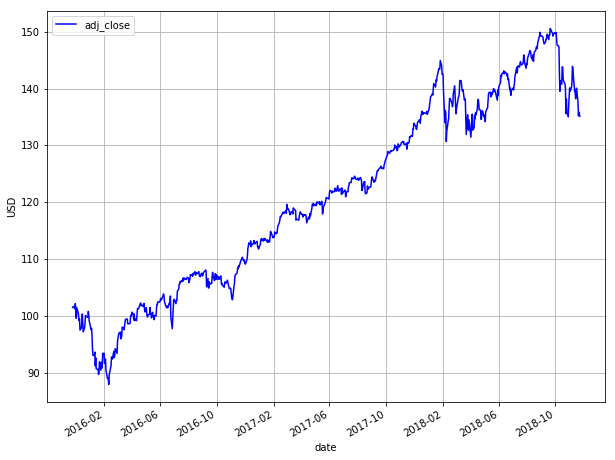

In [385]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Feature Engineering

We will generate the following features:
* Mean 'adj_close' of each month
* Difference between high and low of each day
* Difference between open and close of each day
* Mean volume of each month

In [386]:
# Get difference between high and low of each day
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)

df.head()

,date,adj_close,volume,month,range_hl,range_oc
0,2015-11-25,101.497200,1820300,11,0.410004,0.040001
1,2015-11-27,101.648300,552400,11,0.540001,-0.040001
2,2015-11-30,101.213867,3618100,11,0.739997,0.610001
3,2015-12-01,102.167740,2443600,12,0.839996,-0.590004
4,2015-12-02,101.100533,2937200,12,1.390000,1.049995


Now we use lags up to N number of days to use as features.

In [387]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

['adj_close', 'range_hl', 'range_oc', 'volume']

In [388]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
    
df.head()

A Jupyter Widget

,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_5,volume_lag_5,adj_close_lag_6,range_hl_lag_6,range_oc_lag_6,volume_lag_6,adj_close_lag_7,range_hl_lag_7,range_oc_lag_7,volume_lag_7
7,2015-12-07,100.628342,3000500,12,1.209999,0.680000,7,101.421646,1.919998,-1.580001,...,0.610001,3618100.0,101.648300,0.540001,-0.040001,552400.0,101.497200,0.410004,0.040001,1820300.0
8,2015-12-08,100.023895,3149600,12,1.130005,0.029998,8,100.628342,1.209999,0.680000,...,-0.590004,2443600.0,101.213867,0.739997,0.610001,3618100.0,101.648300,0.540001,-0.040001,552400.0
9,2015-12-09,99.164467,4179800,12,2.269997,0.550003,9,100.023895,1.130005,0.029998,...,1.049995,2937200.0,102.167740,0.839996,-0.590004,2443600.0,101.213867,0.739997,0.610001,3618100.0
10,2015-12-10,99.457237,3684900,12,1.140000,-0.129998,10,99.164467,2.269997,0.550003,...,1.840004,3345600.0,101.100533,1.390000,1.049995,2937200.0,102.167740,0.839996,-0.590004,2443600.0
11,2015-12-11,97.502281,5100700,12,1.360000,0.930000,11,99.457237,1.140000,-0.129998,...,-1.580001,4520000.0,99.589470,2.420005,1.840004,3345600.0,101.100533,1.390000,1.049995,2937200.0


In [389]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 748 entries, 7 to 754
Data columns (total 35 columns):
date               748 non-null datetime64[ns]
adj_close          748 non-null float64
volume             748 non-null int64
month              748 non-null int64
range_hl           748 non-null float64
range_oc           748 non-null float64
order_day          748 non-null int64
adj_close_lag_1    748 non-null float64
range_hl_lag_1     748 non-null float64
range_oc_lag_1     748 non-null float64
volume_lag_1       748 non-null float64
adj_close_lag_2    748 non-null float64
range_hl_lag_2     748 non-null float64
range_oc_lag_2     748 non-null float64
volume_lag_2       748 non-null float64
adj_close_lag_3    748 non-null float64
range_hl_lag_3     748 non-null float64
range_oc_lag_3     748 non-null float64
volume_lag_3       748 non-null float64
adj_close_lag_4    748 non-null float64
range_hl_lag_4     748 non-null float64
range_oc_lag_4     748 non-null float64
volume_lag_4  

In [390]:
# # Get mean of adj_close of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'adj_close':'mean'})
# df_gb = df_gb.rename(columns={'adj_close':'adj_close_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# # Merge to main df
# shift_range = [x+1 for x in range(2)]

# for shift in tqdm_notebook(shift_range):
#     train_shift = df[merging_keys + lag_cols].copy()
    
#     # E.g. order_day of 0 becomes 1, for shift = 1.
#     # So when this is merged with order_day of 1 in df, this will represent lag of 1.
#     train_shift['order_day'] = train_shift['order_day'] + shift
    
#     foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
#     train_shift = train_shift.rename(columns=foo)

#     df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
# del train_shift
    
# df

In [391]:
# # Get mean of volume of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'volume':'mean'})
# df_gb = df_gb.rename(columns={'volume':'volume_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# df.head()

# Get mean and std dev at timestamp t using values from t-1, ..., t-N

In [392]:
cols_list = [
"adj_close",
"range_hl",
"range_oc",
"volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_7,volume_lag_7,adj_close_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
7,2015-12-07,100.628342,3000500,12,1.209999,0.680000,7,101.421646,1.919998,-1.580001,...,0.040001,1820300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2015-12-08,100.023895,3149600,12,1.130005,0.029998,8,100.628342,1.209999,0.680000,...,-0.040001,552400.0,100.628342,NaN,1.209999,NaN,0.680000,NaN,3000500.0,NaN
9,2015-12-09,99.164467,4179800,12,2.269997,0.550003,9,100.023895,1.130005,0.029998,...,0.610001,3618100.0,100.326119,0.427409,1.170002,0.056564,0.354999,0.459621,3075050.0,105429.621075
10,2015-12-10,99.457237,3684900,12,1.140000,-0.129998,10,99.164467,2.269997,0.550003,...,-0.590004,2443600.0,99.938901,0.735629,1.536667,0.636341,0.420000,0.343949,3443300.0,642169.673840
11,2015-12-11,97.502281,5100700,12,1.360000,0.930000,11,99.457237,1.140000,-0.129998,...,1.049995,2937200.0,99.818485,0.647122,1.437500,0.556138,0.282501,0.393055,3503700.0,538064.958904


# Split into train, dev and test set

In [393]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 450
num_cv = 149
num_test = 149
train.shape = (450, 43)
cv.shape = (149, 43)
train_cv.shape = (599, 43)
test.shape = (149, 43)


# Scale the train, dev and test set

In [394]:
cols_to_scale = [
"adj_close",
"adj_close_lag_1",
"range_hl_lag_1",
"range_oc_lag_1",
"volume_lag_1",
"adj_close_lag_2",
"range_hl_lag_2",
"range_oc_lag_2",
"volume_lag_2",
"adj_close_lag_3",
"range_hl_lag_3",
"range_oc_lag_3",
"volume_lag_3",
"adj_close_lag_4",
"range_hl_lag_4",
"range_oc_lag_4",
"volume_lag_4",
"adj_close_lag_5",
"range_hl_lag_5",
"range_oc_lag_5",
"volume_lag_5",
"adj_close_lag_6",
"range_hl_lag_6",
"range_oc_lag_6",
"volume_lag_6",
"adj_close_lag_7",
"range_hl_lag_7",
"range_oc_lag_7",
"volume_lag_7"
]

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [ 1.09363627e+02  1.09308711e+02  8.89310976e-01 -1.79333622e-02
  2.58809600e+06  1.09249855e+02  8.93777644e-01 -1.37111356e-02
  2.59154778e+06  1.09195030e+02  8.95933204e-01 -1.07333511e-02
  2.59467200e+06  1.09143098e+02  8.96888776e-01 -1.17555711e-02
  2.59678400e+06  1.09088960e+02  8.97888749e-01 -1.00222400e-02
  2.60106311e+06  1.09035917e+02  8.98333204e-01 -9.44445778e-03
  2.59725911e+06  1.08983604e+02  8.97555431e-01 -7.80002000e-03
  2.59831200e+06]
scaler.var_ = [9.72963234e+01 9.68085151e+01 2.30983608e-01 3.46406442e-01
 1.89070130e+12 9.63902924e+01 2.35659854e-01 3.54055641e-01
 1.89055721e+12 9.59282625e+01 2.35703584e-01 3.56391509e-01
 1.88831489e+12 9.54418388e+01 2.35184865e-01 3.57104528e-01
 1.88566506e+12 9.49785274e+01 2.34420114e-01 3.57904947e-01
 1.88614754e+12 9.44989771e+01 2.34012893e-01 3.57719746e-01
 1.89520761e+12 9.40534825e+01 2.34499687e-01 3.56662783e-01
 1.89307154e+12]
train_scaled.shape = (450, 29)
train_scaled.shape = (4

,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,...,adj_close_lag_6,range_hl_lag_6,range_oc_lag_6,volume_lag_6,adj_close_lag_7,range_hl_lag_7,range_oc_lag_7,volume_lag_7,date,month
0,-0.885582,-0.801602,2.144550,-2.654036,1.404993,-0.983961,3.143956,3.115353,0.548411,-0.826450,...,-0.759960,-0.740740,-0.051090,-1.485371,-0.771944,-1.006814,0.080040,-0.565461,2015-12-07,12
1,-0.946861,-0.882229,0.667256,1.185826,0.299924,-0.797344,2.113965,-2.632306,1.402536,-0.980730,...,-0.804650,-0.327311,1.035694,0.741532,-0.756364,-0.738365,-0.053919,-1.486974,2015-12-08,12
2,-1.033990,-0.943662,0.500812,0.081438,0.408358,-0.878146,0.651401,1.165851,0.297425,-0.793664,...,-0.706526,-0.120594,-0.970678,-0.111617,-0.801159,-0.325365,1.034474,0.741185,2015-12-09,12
3,-1.004309,-1.031010,2.872793,0.964954,1.157580,-0.939712,0.486617,0.073458,0.405863,-0.874661,...,-0.816309,1.016368,1.771351,0.246931,-0.702803,-0.118863,-0.974869,-0.112445,2015-12-10,12
4,-1.202502,-1.001254,0.521609,-0.190404,0.797660,-1.027250,2.834946,0.947378,1.155113,-0.936375,...,-0.971751,3.145583,3.092223,0.543590,-0.812845,1.016919,1.771220,0.246305,2015-12-11,12


In [395]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [ 1.15615132e+02  1.15559769e+02  9.89231968e-01 -2.05348080e-03
  2.63217963e+06  1.15498617e+02  9.91018277e-01  4.67390651e-04
  2.63436978e+06  1.15439904e+02  9.90600917e-01  4.50691152e-04
  2.63648598e+06  1.15381154e+02  9.90066705e-01 -1.16866444e-03
  2.63388114e+06  1.15319554e+02  9.90033294e-01 -4.50786311e-04
  2.63732638e+06  1.15258993e+02  9.89098394e-01  2.16994992e-04
  2.63454257e+06  1.15200579e+02  9.87812937e-01  5.84288815e-04
  2.63275242e+06]
scaler_train_cv.var_ = [1.96355173e+02 1.96087706e+02 5.20941512e-01 5.83055733e-01
 2.01657120e+12 1.95797191e+02 5.24138578e-01 5.88530037e-01
 2.01681814e+12 1.95419603e+02 5.23701025e-01 5.88494817e-01
 2.01541287e+12 1.94908122e+02 5.23690706e-01 5.88833741e-01
 2.01234662e+12 1.94376778e+02 5.23706746e-01 5.89402023e-01
 2.01200655e+12 1.93832098e+02 5.24023794e-01 5.89081642e-01
 2.01896487e+12 1.93392544e+02 5.24521156e-01 5.89029924e-01
 2.01995732e+12]
train_cv_scaled.shape = (599, 29)
tr

,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,...,adj_close_lag_6,range_hl_lag_6,range_oc_lag_6,volume_lag_6,adj_close_lag_7,range_hl_lag_7,range_oc_lag_7,volume_lag_7,date,month
0,-1.069516,-1.009640,1.289573,-2.066510,1.329395,-1.136956,1.973809,2.397862,0.500814,-1.025761,...,-0.977614,-0.620390,-0.052400,-1.465366,-0.985389,-0.797816,0.051358,-0.571646,2015-12-07,12
1,-1.112652,-1.066292,0.305872,0.893230,0.259370,-1.006019,1.283167,-2.060163,1.327771,-1.133854,...,-1.008818,-0.344113,0.794490,0.692206,-0.974524,-0.618321,-0.052881,-1.463746,2015-12-08,12
2,-1.173984,-1.109457,0.195041,0.041975,0.364365,-1.062712,0.302470,0.885780,0.257811,-1.002790,...,-0.940304,-0.205972,-0.769001,-0.134381,-1.005763,-0.342175,0.794046,0.693295,2015-12-09,12
3,-1.153091,-1.170831,1.774496,0.722984,1.089827,-1.105910,0.191977,0.038494,0.362801,-1.059539,...,-1.016958,0.553812,1.367759,0.213004,-0.937172,-0.204100,-0.769513,-0.133089,2015-12-10,12
4,-1.292604,-1.149924,0.208889,-0.167559,0.741321,-1.167329,1.766608,0.716327,1.088218,-1.102778,...,-1.125493,1.976677,2.397065,0.500426,-1.013913,0.555324,1.367341,0.214211,2015-12-11,12


In [396]:
# Do scaling for dev set
cv_scaled = cv[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
# Now the entire dev set is scaled
cv_scaled.head()

A Jupyter Widget

,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,adj_close_lag_4,adj_close_lag_5,adj_close_lag_6,adj_close_lag_7,range_hl_lag_1,range_hl_lag_2,...,range_oc_lag_5,range_oc_lag_6,range_oc_lag_7,volume_lag_1,volume_lag_2,volume_lag_3,volume_lag_4,volume_lag_5,volume_lag_6,volume_lag_7
457,2017-09-20,1.256228,1.099169,0.287905,-0.340231,-0.235558,-0.392556,-1.674958,-0.966199,-0.008525,...,0.211743,-0.309015,-1.911256,-1.123281,0.498320,-0.270365,-0.382575,0.204394,1.888137,-0.814629
458,2017-09-21,1.474617,0.855312,0.678318,-0.235914,-0.943775,-0.825817,-1.002741,1.879615,-1.196107,...,0.031365,-0.261648,-1.214144,0.161884,-1.372638,0.360506,-0.461054,-0.580982,0.046362,1.845923
459,2017-09-22,0.233631,1.411044,0.724248,0.527966,-0.485899,-1.270901,-1.140089,0.086959,1.825534,...,-1.256634,-0.423842,-0.631999,0.668273,0.661024,-1.863309,0.987763,-0.363726,-0.561012,0.470987
460,2017-09-25,0.373492,-0.012482,1.330968,0.547321,0.323359,-0.833478,-1.729180,0.258554,-0.122417,...,-0.014295,-1.166421,-0.364962,0.069011,0.751562,0.744154,-1.835253,1.078022,-0.302953,-0.504543
461,2017-09-26,-0.860187,0.265346,-0.286640,1.634644,0.513942,0.193651,-1.460756,1.701939,-0.126050,...,0.578120,-0.162147,-1.297312,1.737920,-0.299590,0.150168,0.145287,-1.554381,0.365285,-0.544691


In [397]:
# Do scaling for test set
test_scaled = test[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled.head()

A Jupyter Widget

,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,adj_close_lag_4,adj_close_lag_5,adj_close_lag_6,adj_close_lag_7,range_hl_lag_1,range_hl_lag_2,...,range_oc_lag_5,range_oc_lag_6,range_oc_lag_7,volume_lag_1,volume_lag_2,volume_lag_3,volume_lag_4,volume_lag_5,volume_lag_6,volume_lag_7
606,2018-04-25,-1.747066,-0.401819,-0.361060,0.535776,1.155382,1.000480,-0.181693,2.154173,-0.180210,...,-0.369310,-1.045583,-0.761988,0.643878,-0.520679,-0.936461,1.729184,-1.068014,-0.308048,0.460139
607,2018-04-26,-1.205467,-1.309393,-0.166268,-0.131632,0.630455,1.156967,1.025339,0.085362,2.105090,...,-0.151160,-0.369313,-1.045587,-0.146734,0.758789,-0.428015,-0.851740,1.864827,-0.985805,-0.211322
608,2018-04-27,-0.135124,-1.135322,-1.251631,0.027693,0.066455,0.919342,1.508586,-0.227889,0.029799,...,0.599331,-0.101616,-0.307772,-1.025160,0.007849,0.819097,-0.244147,-0.623758,1.809985,-0.743866
609,2018-04-30,0.212680,0.119640,-1.214048,-1.369137,0.336744,0.388431,1.525690,-0.892649,-0.269075,...,-0.157800,0.595818,-0.106194,-1.050613,-0.902923,0.066160,0.827206,-0.170242,-0.526362,1.756774
610,2018-05-01,-0.630842,0.711381,0.590591,-1.140894,-1.342240,0.872451,0.939553,0.020776,-1.036604,...,1.643083,-0.286907,0.428263,0.477824,-1.251107,-1.022801,0.475254,1.651713,0.109812,-0.440694


# Split into X and y

In [398]:
features = [
"adj_close_lag_1",
"range_hl_lag_1",
"range_oc_lag_1",
"volume_lag_1",
"adj_close_lag_2",
"range_hl_lag_2",
"range_oc_lag_2",
"volume_lag_2",
"adj_close_lag_3",
"range_hl_lag_3",
"range_oc_lag_3",
"volume_lag_3",
"adj_close_lag_4",
"range_hl_lag_4",
"range_oc_lag_4",
"volume_lag_4",
"adj_close_lag_5",
"range_hl_lag_5",
"range_oc_lag_5",
"volume_lag_5",
"adj_close_lag_6",
"range_hl_lag_6",
"range_oc_lag_6",
"volume_lag_6",
"adj_close_lag_7",
"range_hl_lag_7",
"range_oc_lag_7",
"volume_lag_7"
]

target = "adj_close"


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (450, 28)
y_train.shape = (450,)
X_cv.shape = (149, 28)
y_cv.shape = (149,)
X_train_cv.shape = (599, 28)
y_train_cv.shape = (599,)
X_sample.shape = (149, 28)
y_sample.shape = (149,)


In [399]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (450, 28)
y_train_scaled.shape = (450,)
X_cv_scaled.shape = (149, 28)
X_train_cv_scaled.shape = (599, 28)
y_train_cv_scaled.shape = (599,)
X_sample_scaled.shape = (149, 28)


# EDA

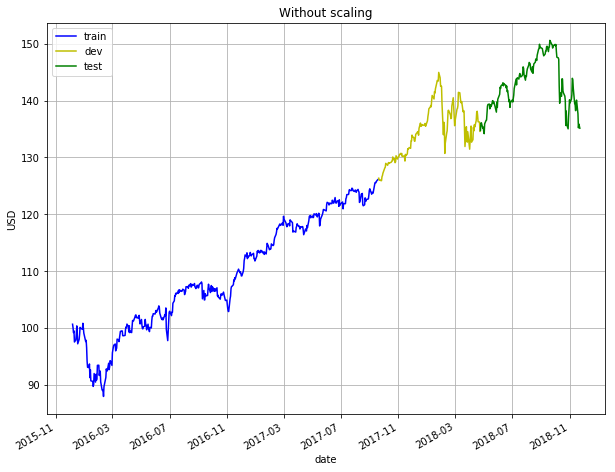

In [400]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

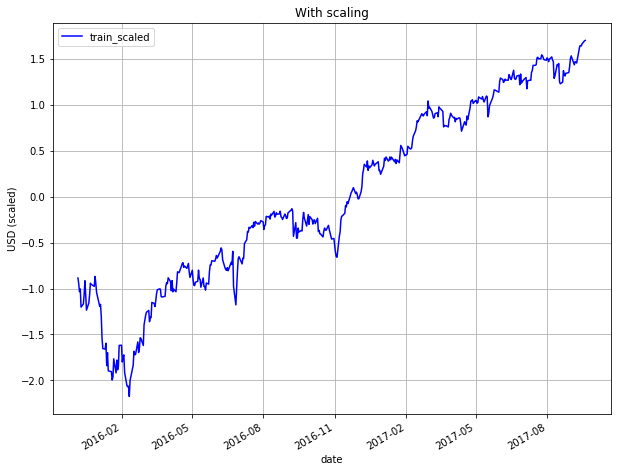

In [401]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train_scaled.plot(x='date', y='adj_close', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

# Train the model using XGBoost

In [402]:
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
       silent=True, subsample=1)

# Predict on train set

In [403]:
# Do prediction on train set
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 0.364
MAPE on train set = 0.246%


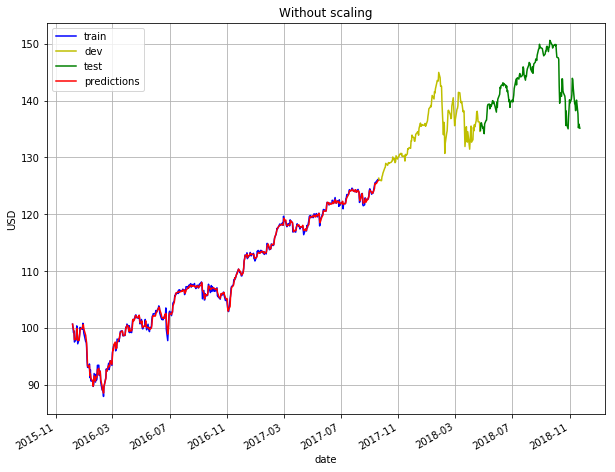

In [404]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

# Predict on dev set

In [405]:
# Do prediction on test set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

RMSE on dev set = 1.251
MAPE on dev set = 0.612%


/Users/yibin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yibin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


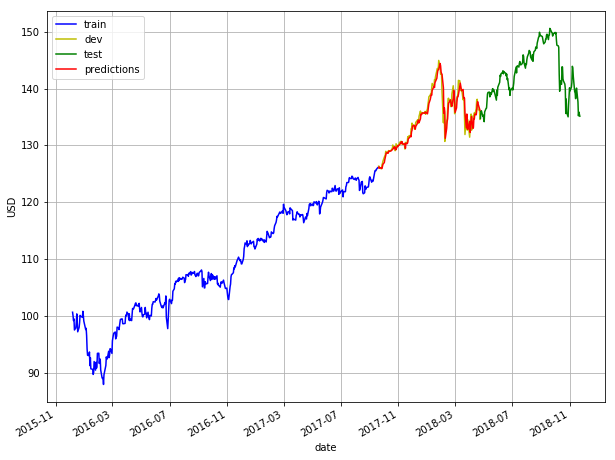

In [406]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

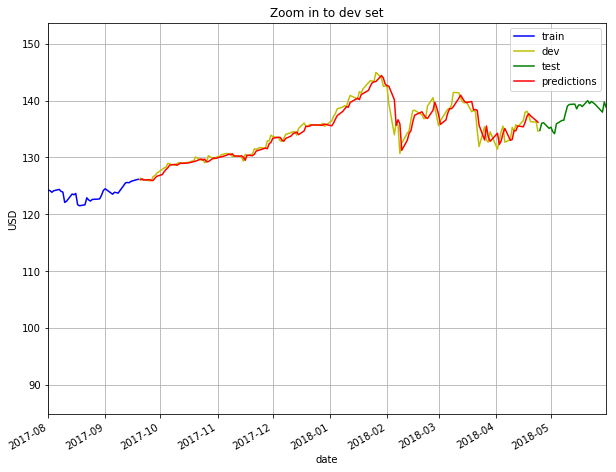

In [407]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 8, 1), date(2018, 5, 31)])
ax.set_title("Zoom in to dev set")

The predictions capture the turn in directions with a slight lag

In [408]:
# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('volume_lag_7', 0.032307692),
 ('range_oc_lag_1', 0.033846155),
 ('volume_lag_4', 0.033846155),
 ('range_oc_lag_5', 0.033846155),
 ('adj_close_lag_7', 0.033846155),
 ('volume_lag_3', 0.03846154),
 ('volume_lag_2', 0.04),
 ('adj_close_lag_5', 0.04),
 ('adj_close_lag_2', 0.05846154),
 ('adj_close_lag_1', 0.2923077)]

Importance features dominated by adj_close and volume

# Tuning XGBoost - n_estimators (default=100) and max_depth (default=3)

In [409]:
param_label = 'n_estimators'
param_list = range(10, 310, 10)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

A Jupyter Widget


Minutes taken = 0.6851722836494446


,n_estimators,max_depth,rmse,mape_pct
0,10,2,1.424572,0.662847
1,10,3,1.410504,0.657708
2,10,4,1.395200,0.653646
3,10,5,1.400480,0.653392
4,10,6,1.394659,0.651882
5,10,7,1.394507,0.651669
6,10,8,1.394617,0.651694
7,10,9,1.394617,0.651694
8,20,2,1.295366,0.623357
9,20,3,1.277116,0.612218


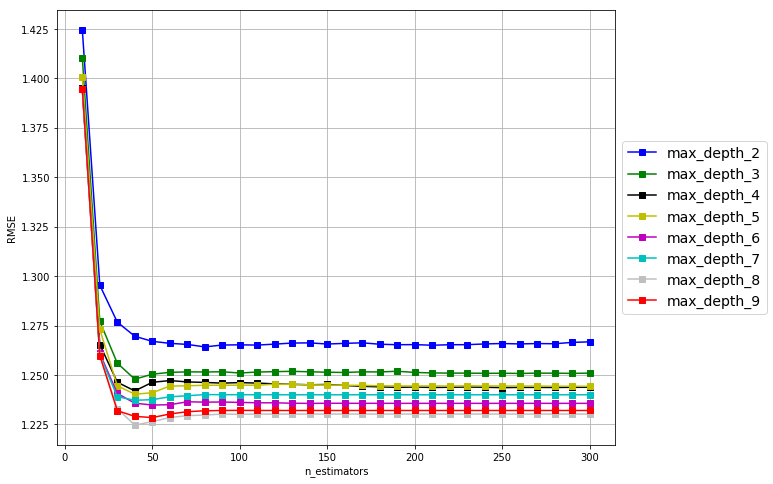

In [410]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [411]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 1.225
optimum params = 


(40, 8)

In [412]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 0.609%
optimum params = 


(40, 3)

# Tuning XGBoost - learning_rate(default=0.1) and min_child_weight(default=1)

In [413]:
param_label = 'learning_rate'
param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

A Jupyter Widget


Minutes taken = 0.11904533306757609


,learning_rate,min_child_weight,rmse,mape_pct
0,0.001,5,2.107874,0.961401
1,0.001,6,2.107874,0.961401
2,0.001,7,2.107870,0.961389
3,0.001,8,2.107861,0.961382
4,0.001,9,2.107861,0.961382
5,0.001,10,2.107861,0.961382
6,0.001,11,2.107861,0.961382
7,0.001,12,2.107861,0.961382
8,0.001,13,2.107831,0.961364
9,0.001,14,2.107878,0.961354


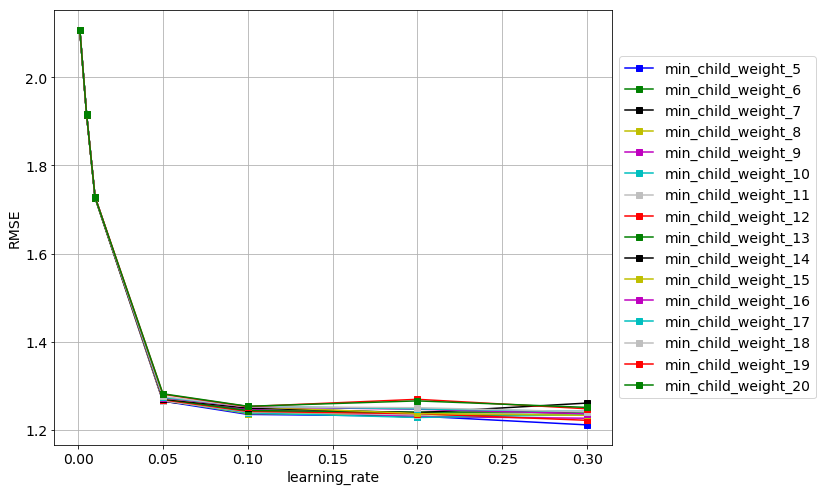

In [414]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [415]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 1.211
optimum params = 


(0.3, 5)

In [416]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 0.602%
optimum params = 


(0.3, 5)

# Tuning XGBoost - subsample(default=1) and gamma(default=0)

In [417]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

A Jupyter Widget


Minutes taken = 0.10207071701685587


,subsample,gamma,rmse,mape_pct
0,0.1,0.1,1.367103,0.650224
1,0.1,0.2,1.344888,0.655029
2,0.1,0.3,1.347047,0.655467
3,0.1,0.4,1.311882,0.634172
4,0.1,0.5,1.244510,0.601532
5,0.1,0.6,1.239820,0.602800
6,0.1,0.7,1.257183,0.611067
7,0.1,0.8,1.244019,0.609177
8,0.1,0.9,1.267261,0.616629
9,0.1,1.0,1.306810,0.637835


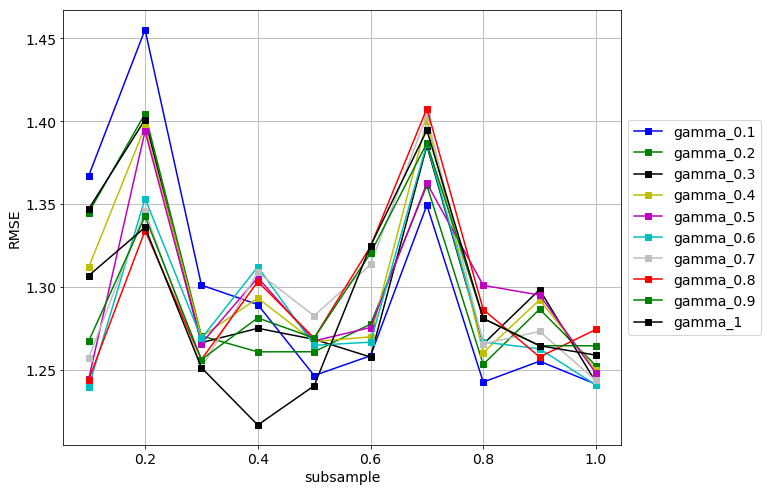

In [418]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [419]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 1.217
optimum params = 


(0.4, 1.0)

In [420]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 0.592%
optimum params = 


(0.4, 1.0)

# Tuning XGBoost - colsample_bytree(default=1) and colsample_bylevel(default=1)

In [421]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

A Jupyter Widget


Minutes taken = 0.02188584804534912


,colsample_bytree,colsample_bylevel,rmse,mape_pct
0,0.5,0.5,1.629055,0.825991
1,0.5,0.6,1.548466,0.775203
2,0.5,0.7,1.511302,0.747095
3,0.5,0.8,1.473611,0.726081
4,0.5,0.9,1.473611,0.726081
5,0.5,1.0,1.527126,0.767908
6,0.6,0.5,1.652457,0.857276
7,0.6,0.6,1.608750,0.803872
8,0.6,0.7,1.522242,0.728545
9,0.6,0.8,1.504116,0.704773


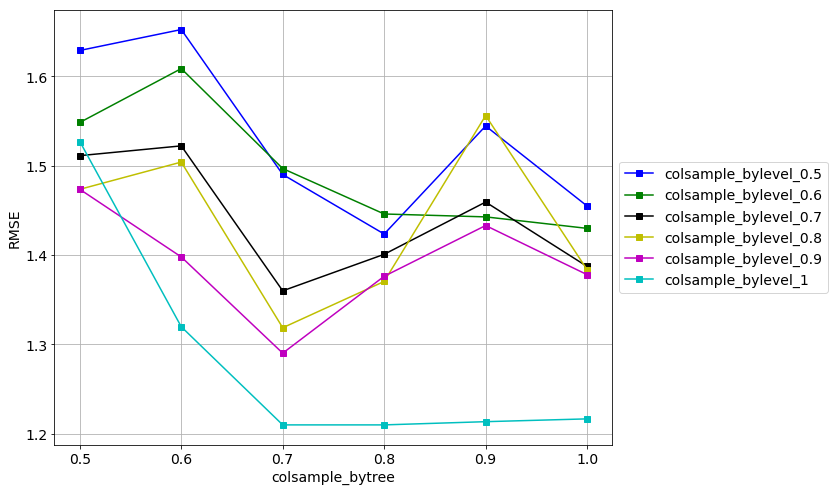

In [422]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [423]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 1.210
optimum params = 


(0.7, 1.0)

In [424]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 0.590%
optimum params = 


(0.7, 1.0)

# Tuned params

In [425]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params

,param,original,after_tuning
0,n_estimators,100.000000,40.000000
1,max_depth,3.000000,8.000000
2,learning_rate,0.100000,0.300000
3,min_child_weight,1.000000,5.000000
4,subsample,1.000000,0.400000
5,colsample_bytree,1.000000,0.700000
6,colsample_bylevel,1.000000,1.000000
7,gamma,0.000000,1.000000
8,rmse,1.250977,1.209911
9,mape_pct,0.611868,0.590326


# Final model

In [427]:
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_sample_scaled, 
                             y_sample, 
                             test['adj_close_mean'],
                             test['adj_close_std'],
                             seed=model_seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 1.170
MAPE on test set = 0.586%


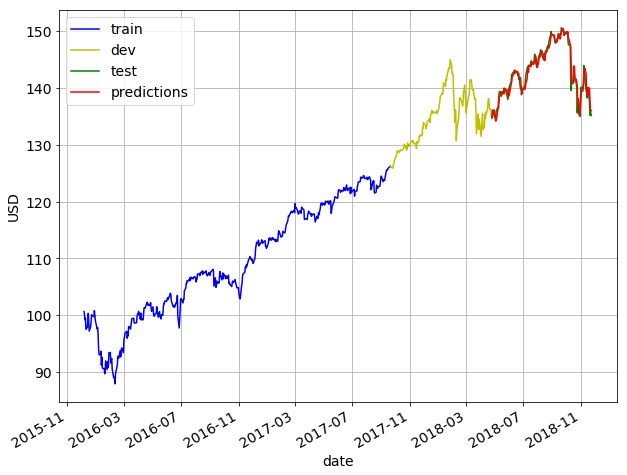

In [428]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

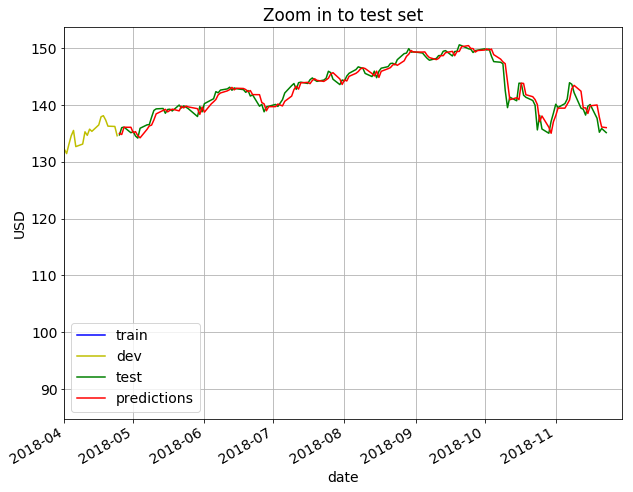

In [429]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 1), date(2018, 11, 30)])
ax.set_title("Zoom in to test set")

Similar to dev set, the predictions capture turns in direction with a slight lag

# Findings
* By scaling the features properly, we can get good results for our predictions
* After hyperparameter tuning, RMSE dropped from 1.25 to 1.21, MAPE dropped from 0.61% to 0.59%